# IonSolvR MD trajectories

## Description

IonSolvR (DOI: 10.1038/s41597-022-01527-8) is a dataset of solvated ion structures. It was generated using AIMD, with semiempirical density functional tight-binding (DFTB3) as the source of energies and forces.

Trajectories were performed for combinations of 55 solutes and 28 solvents (protic and aprotic). Each trajectory contains one solute (in most cases a single ion; in some cases, a formula unit like MgO or MgCl2) and some number of solvent (between 4 and 300). Not all combinations of solute, solvent, and system size were attempted.

Each trajectory is packaged as a *.zip file with four components: an *.xyz file, containing the coordinates, velocities, and partial charges of each atom in each snapshot; an *.out file, containing some overall system information for each snapshot (pressure, temperature, total energy, etc.); and two folders, one containing the initial information about the system and one containing all data for the final second of the simulation.

## Objective

We want to extract "diverse" snapshots from IonSolvR. "Diverse" is somewhat nebulous but can refer to 

Mostly, we are interested in small clusters around the solvated ion(s) (i.e. first solvation shells). However, for some systems, it may be possible and important to also perform calculations on larger clusters, for instance second solvation shells or perhaps even the entire simulation box

This notebook contains the steps necessary to load in a trajectory from IonSolvR, perform some preprocessing, identify solvation environments around the ions, and extract these as ASE Atoms objects for further calculation.

## Strategy

1. For each trajectory, group first solvation shells by topology. That is, separate different types of local environments. Solvent-separated ion pairs are separate from contact-ion pairs, 4-fold coordination is separate from 5-fold coordination, etc.
2. (Inspired by SPICE) within each group, select `n` solvent shells that are maximally different, as measured by some metric like RMSD
3. In addition, for `m` random snapshots where the innser solvent shell was NOT chosen, extract larger solvent shell.

## Questions

1. For the larger (non-first-shell) calculations, should they all use the same cutoffs? Should they be variable?

In [22]:
import os
import copy
from collections import defaultdict
import itertools

from IPython.core.display import Image

import numpy as np
import matplotlib.pyplot as plt

import MDAnalysis as mda
import MDAnalysis.transformations
import nglview as nv

# Now to extract the first solvation shells 
import solvation_analysis
from solvation_analysis.solute import Solute
from solvation_analysis._column_names import *

from pymatgen.core.structure import Molecule

In [2]:
base_dir = "/home/ewcss/data/omol24/20240126_ionsolvr_test/water_formate_32"

# Bookkeeping - creating universe with certain number of atoms, "residues" (molecules) and "segments"
solute_natoms = 4
solvent_natoms = 3
nsolvent = 32
natoms = solute_natoms + solvent_natoms * nsolvent

# Residue assignment is easy because of how IonSolvR trajectories are organized
resindices = np.concatenate((np.zeros(solute_natoms), np.repeat(range(1, nsolvent + 1), solvent_natoms)), axis=None)

# Segments likewise straightforward
# Solute is one segment; solvent is another
# This is pretty arbitrary; I don't think we'll actually do anything on the segment level
segindices = [0] + [1] * nsolvent

In [3]:
universe = mda.Universe.empty(natoms,
                              n_residues=1 + nsolvent,
                              atom_resindex=resindices,
                              residue_segindex=segindices,
                              trajectory=True) # necessary for adding coordinates

gen_file = os.path.join(base_dir, "FINAL_run", "geom.gen")

# More bookkeeping - assigning some basic attributes
universe.add_TopologyAttr('name', ['C', 'O1', 'O2', 'H1'] + ['O3', 'H2', 'H3'] * nsolvent)
universe.add_TopologyAttr('type', ['C', 'O', 'O', 'H'] + ['O', 'H', 'H'] * nsolvent)
universe.add_TopologyAttr('resname', ['solute'] + ['solvent'] * nsolvent)
universe.add_TopologyAttr('resid', list(range(0, nsolvent + 1)))
universe.add_TopologyAttr('elements', ['C', 'O', 'O', 'H'] + ['O', 'H', 'H'] * nsolvent)
universe.add_TopologyAttr('masses', [12.011, 15.999, 15.999, 1.008] + [15.999, 1.008, 1.008] * nsolvent)

# Add bonds
solu = universe.select_atoms('resname solute')
co1 = solu.select_atoms('name C or name O1').split('residue')
co2 = solu.select_atoms('name C or name O2').split('residue')
ch = solu.select_atoms('name C or name H1').split('residue')
solv = universe.select_atoms('resname solvent')
oh1 = solv.select_atoms('name O3 or name H2').split('residue')
oh2 = solv.select_atoms('name O3 or name H3').split('residue')
universe.add_bonds(co1 + co2 + ch + oh1 + oh2)

# Add trajectory
universe.load_new(os.path.join(base_dir, "waterformate32.xyz"))

# Add PBC box
with open(gen_file) as file:
    dimension_lines = file.readlines()[-3:]
    a = float(dimension_lines[0].split()[0])
    b = float(dimension_lines[1].split()[1])
    c = float(dimension_lines[2].split()[2])
    universe.dimensions = [a, b, c, 90, 90, 90]

print(universe.dimensions)


[10.115503 10.115503 10.115503 90.       90.       90.      ]


In [5]:
# Put the solute in the center of the box at all time steps
for ts in universe.trajectory:
    ts.dimensions = universe.dimensions
    
    solu.unwrap(compound='fragments')
    
    solu_center = solu.center_of_mass(pbc=True)
    dim = ts.triclinic_dimensions
    box_center = np.sum(dim, axis=0) / 2
    universe.atoms.translate(box_center - solu_center)

    solv.wrap(compound='residues')

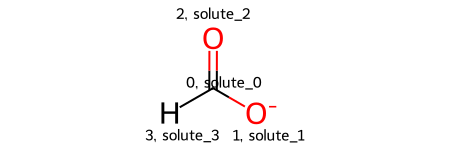

In [6]:
distance_cutoff = 2.4

solute = universe.select_atoms("resname solute")
solvent = universe.atoms - solute

solv_anal = Solute.from_atoms(solute, {'solvent': solvent}, solute_name="solute", radii={'solvent': distance_cutoff})

solv_anal.draw_molecule('solute')

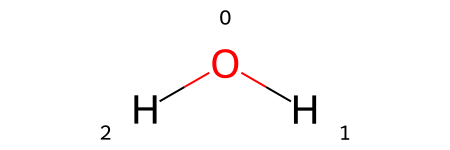

In [7]:
solv_anal.draw_molecule('solvent')

In [8]:
# Identify the cutoff for the first solvation shell, based on the MD trajectory
# This could take a while
solv_anal.run()

/home/ewcss/.conda/envs/omol24/lib/python3.11/site-packages/MDAnalysis/analysis/base.py:447: UserWarning: Reader has no dt information, set to 1.0 ps
  self.times[i] = ts.time
/home/ewcss/.conda/envs/omol24/lib/python3.11/site-packages/MDAnalysis/analysis/base.py:447: UserWarning: Reader has no dt information, set to 1.0 ps
  self.times[i] = ts.time
/home/ewcss/.conda/envs/omol24/lib/python3.11/site-packages/MDAnalysis/analysis/base.py:447: UserWarning: Reader has no dt information, set to 1.0 ps
  self.times[i] = ts.time
/home/ewcss/.conda/envs/omol24/lib/python3.11/site-packages/MDAnalysis/analysis/base.py:447: UserWarning: Reader has no dt information, set to 1.0 ps
  self.times[i] = ts.time


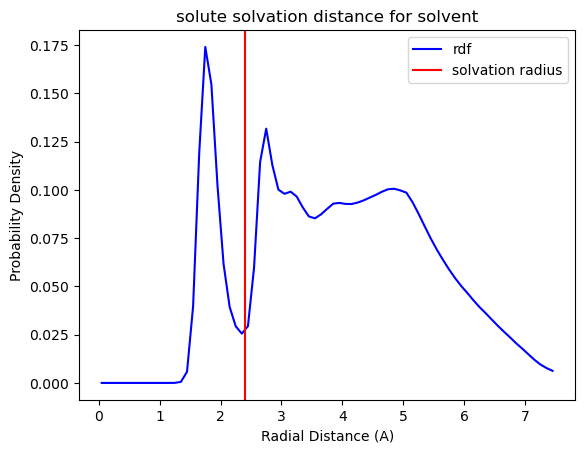

In [9]:
# Plot the RDF
solv_anal.plot_solvation_radius('solute_1', 'solvent')
plt.show()

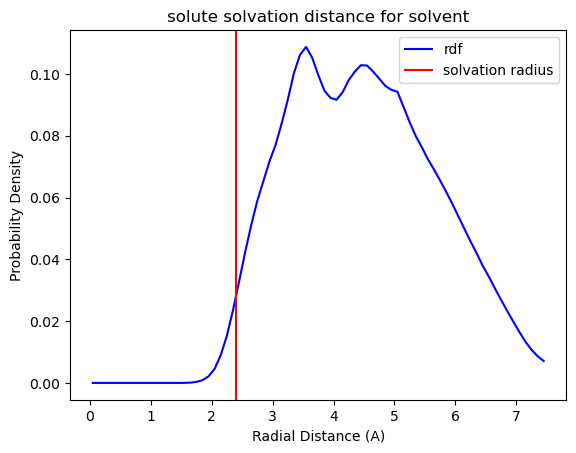

In [10]:
# Plot the RDF
solv_anal.plot_solvation_radius('solute_3', 'solvent')
plt.show()

In [11]:
# NOTE: it seems that the different solvent numbers are based on number of coordinate bonds, NOT number of coordinating molecules
# But these different environments are probably distinct enough to treat separately?

solv_anal.speciation.speciation_fraction

,solvent,count
0,7,0.255977
1,8,0.224988
2,6,0.196268
3,9,0.145879
4,10,0.072339
5,5,0.056919
6,11,0.029980
7,12,0.010170
8,4,0.003700
9,13,0.002810


In [12]:
# There's probably a much faster way to do this
# But for now, we're prototyping, so slow is okay
shells = dict()
for j in solv_anal.speciation.speciation_fraction["solvent"]:
    shells[j] = solv_anal.speciation.get_shells({'solvent': j})

In [13]:
shells[6].head(20)

,solvent,solvent
frame,solute_ix,
16,0,6
19,0,6
21,0,6
47,0,6
60,0,6
61,0,6
63,0,6
64,0,6
68,0,6


In [14]:
# Get one particular solvation shell
frame = 97
solute_id = 0
shell = solv_anal.solvation_data.xs((frame, solute_id), level=(FRAME, SOLUTE_IX))
shell = solv_anal._df_to_atom_group(shell, solute_index=solute_id)

ts = universe.trajectory[frame]

In [15]:
mol = Molecule(shell.atoms.elements, shell.atoms.positions, charge=-1)

In [16]:
data_dir = "/home/ewcss/data/omol24/20240130_ionsolvr_data"
mol.to(os.path.join(data_dir, "water_formate_32_shell6_randomselection_charge-1.xyz"), "xyz")

'22\nH13 C1 O8\nC 5.213629 4.010646 3.787675\nO 5.544917 3.445242 4.909933\nO 4.268933 3.549391 3.023366\nH 5.724914 4.949383 3.430768\nO 2.453162 5.761963 3.259390\nH 2.568051 4.788162 3.248881\nH 2.860272 6.243298 2.495815\nO 5.991415 5.370184 7.172656\nH 6.047399 4.528969 6.675614\nH 6.710037 6.029214 7.028440\nO 3.927344 2.010038 6.552890\nH 4.090507 2.610084 5.770882\nH 3.143106 1.504372 6.200307\nO 1.935280 2.742406 2.130883\nH 1.996951 3.004244 1.185330\nH 2.811399 2.935632 2.535291\nO 8.118183 3.654684 5.401566\nH 8.641659 2.830808 5.544883\nH 7.178913 3.487374 5.141880\nO 3.829306 0.925174 3.727728\nH 4.615089 0.935677 4.324878\nH 3.829990 1.813738 3.338258'

In [17]:
def rmsd(a, b):
    return np.sqrt(np.mean(np.linalg.norm(b - a, axis=1)))

def filter_by_rmsd(coords, n=20):
    """
    From a set of coordinates, determine the n most diverse, where "most diverse" means "most different, in terms of RMSD"

    Because of the way that IonSolvR data is organized, should be able to just directly calculate rmsd on numpy coordinate arrays

    Args:
        coords: list of np.ndarrays. Must all have the same shape, and must all reflect the same atom order!
            Note that this latter requirement shouldn't be a problem, specifically when dealing with IonSolvR data.
    """

    states = {0}
    min_rmsds = np.array([rmsd(coords[0], coords[i]) for i in range(len(coords))])
    for i in range(n - 1):
        best = np.argmax(min_rmsds)
        min_rmsds = np.minimum(min_rmsds, np.array([rmsd(coords[best], coords[i]) for i in range(len(coords))]))
        states.add(best)

    return [coords[i] for i in states]

In [48]:
def reorient(box_dimensions, coords, solute_natoms, solvent_natoms):

    transforms = [np.array(x) * box_dimensions for x in itertools.product([0, -1, 1],[0, -1, 1], [0, -1, 1])]
    
    cog_solu = np.mean(coords[:solute_natoms], axis=0)

    n_solvents = int((len(coords) - solute_natoms) / solvent_natoms)

    final_box = np.zeros(coords.shape)
    final_box[:solute_natoms] = coords[:solute_natoms]
    
    for i in range(n_solvents):
        min_dist = np.inf
        best_coords = np.zeros((solvent_natoms, 3))
        
        start_index = solute_natoms + i * solvent_natoms
        coords_i = coords[start_index:start_index + solvent_natoms]
        assert len(coords_i) == solvent_natoms
        
        for transform in transforms:
            coords_copy = copy.deepcopy(coords_i)
            for i in range(solvent_natoms):
                coords_copy[i] += transform
            
            cog_solv = np.mean(coords_copy, axis=0)
            dist = np.linalg.norm(cog_solv - cog_solu)
            if dist < min_dist:
                min_dist = dist
                best_coords = coords_copy
        final_box[start_index:start_index + solvent_natoms] = best_coords
    return final_box
    

In [49]:
# Now let's try getting the most diverse structures with a particular coordination number
# This is also a bit slow, particularly for the more common and/or larger solvent shells

shell_species = list()
shell_positions = list()
for index, _ in shells[4].iterrows():
    ts = universe.trajectory[index[0]]
    shell = solv_anal.solvation_data.xs((index[0], index[1]), level=(FRAME, SOLUTE_IX))
    shell = solv_anal._df_to_atom_group(shell, solute_index=index[1])
    shell = shell.copy()
    shell.unwrap()
    if len(shell.atoms.elements) > len(shell_species):
        shell_species = shell.atoms.elements
    
    shell_positions.append(reorient(universe.dimensions[:3], shell.atoms.positions, solute_natoms, solvent_natoms))

In [50]:
by_num_atoms = defaultdict(list)
for sps in shell_positions:
    by_num_atoms[len(sps)].append(sps)

selections_by_num_atoms = {k: filter_by_rmsd(v) for k, v in by_num_atoms.items()}
for k, v in selections_by_num_atoms.items():
    print(k, len(v))

16 20
13 3


In [51]:
data_dir = "/home/ewcss/data/omol24/20240130_ionsolvr_data"
for k, v in selections_by_num_atoms.items():
    for ii, positions in enumerate(v):
        mol = Molecule(shell_species[:len(positions)], positions, charge=-1)
        mol.to(os.path.join(data_dir, f"water_formate_32_coord4_size{k}_selection{ii}_charge-1.xyz"), "xyz")